# 24.2 TWFE Bias: When Treatment Effects Vary Over Time

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Implementation](#implementation)
4. [Numeric Demonstration](#numeric)
5. [Interview Appendix](#interview)
6. [References](#references)

---

## Learning Objectives

By the end of this notebook, you will:
- Understand why TWFE fails with time-varying treatment effects
- Decompose TWFE into 2×2 DiD comparisons (Goodman-Bacon)
- Identify "forbidden comparisons" that cause bias
- See how bias can even reverse the sign of the true effect

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from toolz import curry
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

set_notebook_style()
np.random.seed(1)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Intuition <a name="intuition"></a>

### The Problem: Effects Take Time to Mature

In practice, treatment effects rarely appear instantly:

- **Marketing campaign**: Takes weeks for awareness to build
- **New app feature**: Users need time to discover and adopt
- **Policy change**: Behavioral adjustment is gradual

When the ATT **changes over time** (e.g., ramps up, or decays), TWFE breaks.

### TWFE as a Weighted Average of 2×2 DiDs

Goodman-Bacon (2021) showed that TWFE is actually a weighted average of all possible 2×2 DiD comparisons:

1. **Early treated vs Never treated** ✓ (valid)
2. **Late treated vs Never treated** ✓ (valid)
3. **Early treated vs Late treated** (before late treatment) ✓ (valid)
4. **Late treated vs Early treated** (after early treatment) ✗ **PROBLEM!**

### The Forbidden Comparison

In comparison (4), **early treated units serve as controls** for late treated units.

If the early treatment effect is still *changing* when late treatment begins:
- The "control" trend is contaminated by treatment dynamics
- Counterfactual is estimated incorrectly
- Bias results

---

## 2. Formal Treatment <a name="formal"></a>

### Goodman-Bacon Decomposition

Under strict exogeneity but with treatment effect heterogeneity, TWFE converges to:

$$\text{plim}_{n \to \infty} \hat{\tau}^{TWFE} = \text{VWATT} - \Delta\text{ATT}$$

where:
- **VWATT**: Variance-weighted average of treatment effects (what we want)
- **$\Delta$ATT**: Bias term representing *change* in ATT over time

### Bias Direction

| Effect Pattern | Bias Direction | Example |
|----------------|----------------|----------|
| Effect increases over time | Downward bias | Marketing campaign building momentum |
| Effect decreases over time | Upward bias | Initial novelty wearing off |
| Constant effect | No bias | Instantaneous, permanent effect |

### Why Event Study Doesn't Fully Fix It

The event study design adds dummies for time-since-treatment:

$$Y_{it} = \sum_{k=-K}^{L} \tau_k D_{it}^k + \gamma_i + \theta_t + \epsilon_{it}$$

But the problem persists because:
- Still uses early treated as controls for late treated
- The $\tau_k$ coefficients are averages across incompatible comparisons

---

## 3. Implementation <a name="implementation"></a>

### DGP with Time-Heterogeneous Effects

Effect takes 10 days to reach full strength (ramps from 0.1 to 1.0):

In [2]:
# Generate panel with TIME-VARYING treatment effects
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"])
units = range(1, 100+1)

np.random.seed(1)

df_heter = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    # Reduced unit/time FE noise for clearer visualization
    y0 = lambda d: 10 + d["trend"] + 0.2*d["unit_fe"] + 0.05*d["time_fe"] + d["w_seas"]/50,
).assign(
    # TIME-VARYING effect: ramps from 0 to 1 over 10 days
    y1 = lambda d: d["y0"] + np.minimum(
        0.1 * np.maximum(0, (d["date"] - d["cohort"]).dt.days),
        1.0  # Caps at 1.0
    )
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

print("Treatment Effect Pattern:")
print(f"  Days 1-10: Effect ramps from 0.1 to 1.0")
print(f"  Days 11+:  Effect constant at 1.0")
print(f"\nTrue ATT (among treated): {df_heter.query('treat==1')['tau'].mean():.4f}")

Treatment Effect Pattern:
  Days 1-10: Effect ramps from 0.1 to 1.0
  Days 11+:  Effect constant at 1.0

True ATT (among treated): 0.8544


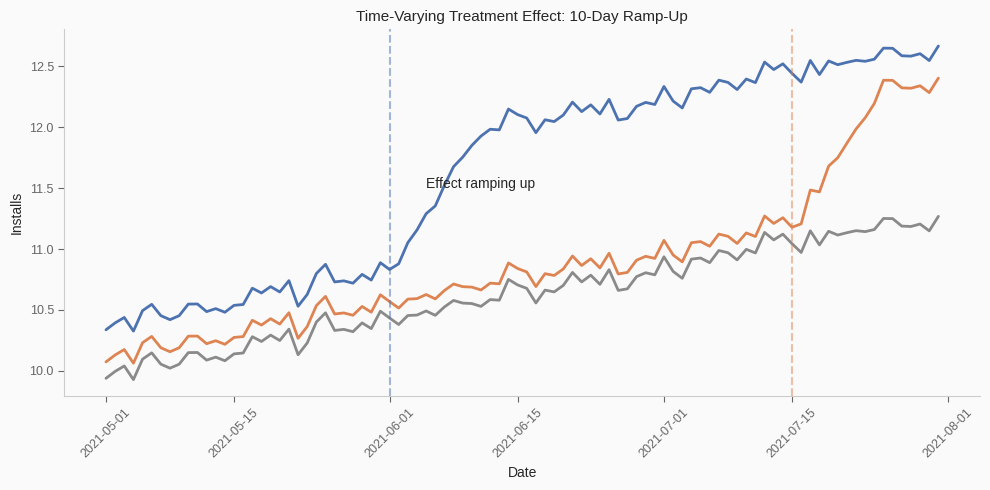

In [3]:
# Visualize the ramping effect
fig, ax = create_tufte_figure(figsize=(10, 5))

cohort_means = df_heter.groupby(["cohort", "date"])["installs"].mean().reset_index()
colors_cohort = [COLORS['blue'], COLORS['orange'], COLORS['gray']]

for cohort_val, color in zip(cohorts, colors_cohort):
    data = cohort_means[cohort_means['cohort'] == cohort_val]
    ax.plot(data['date'], data['installs'], color=color, linewidth=2)

# Treatment lines
ax.axvline(x=pd.Timestamp('2021-06-01'), color=COLORS['blue'], linestyle='--', alpha=0.5)
ax.axvline(x=pd.Timestamp('2021-07-15'), color=COLORS['orange'], linestyle='--', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Installs')
ax.set_title('Time-Varying Treatment Effect: 10-Day Ramp-Up')
ax.annotate('Effect ramping up', xy=(pd.Timestamp('2021-06-05'), 11.5), fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

## 4. Numeric Demonstration <a name="numeric"></a>

### TWFE with Time-Heterogeneous Effects

In [4]:
# Standard TWFE
formula = "installs ~ treat + C(date) + C(unit)"
twfe_model = smf.ols(formula, data=df_heter).fit()

estimated_ate = twfe_model.params["treat"]
true_ate = df_heter.query("treat==1")["tau"].mean()

print("TWFE Results with Time-Varying Effects:")
print(f"  Estimated ATT: {estimated_ate:.4f}")
print(f"  True ATT:      {true_ate:.4f}")
print(f"  Bias:          {estimated_ate - true_ate:.4f} ({100*(estimated_ate - true_ate)/true_ate:.1f}%)")
print(f"\n⚠️  TWFE is BIASED when effects vary over time!")

TWFE Results with Time-Varying Effects:
  Estimated ATT: 0.7868
  True ATT:      0.8544
  Bias:          -0.0676 (-7.9%)

⚠️  TWFE is BIASED when effects vary over time!


### Decomposing TWFE into 2×2 Comparisons

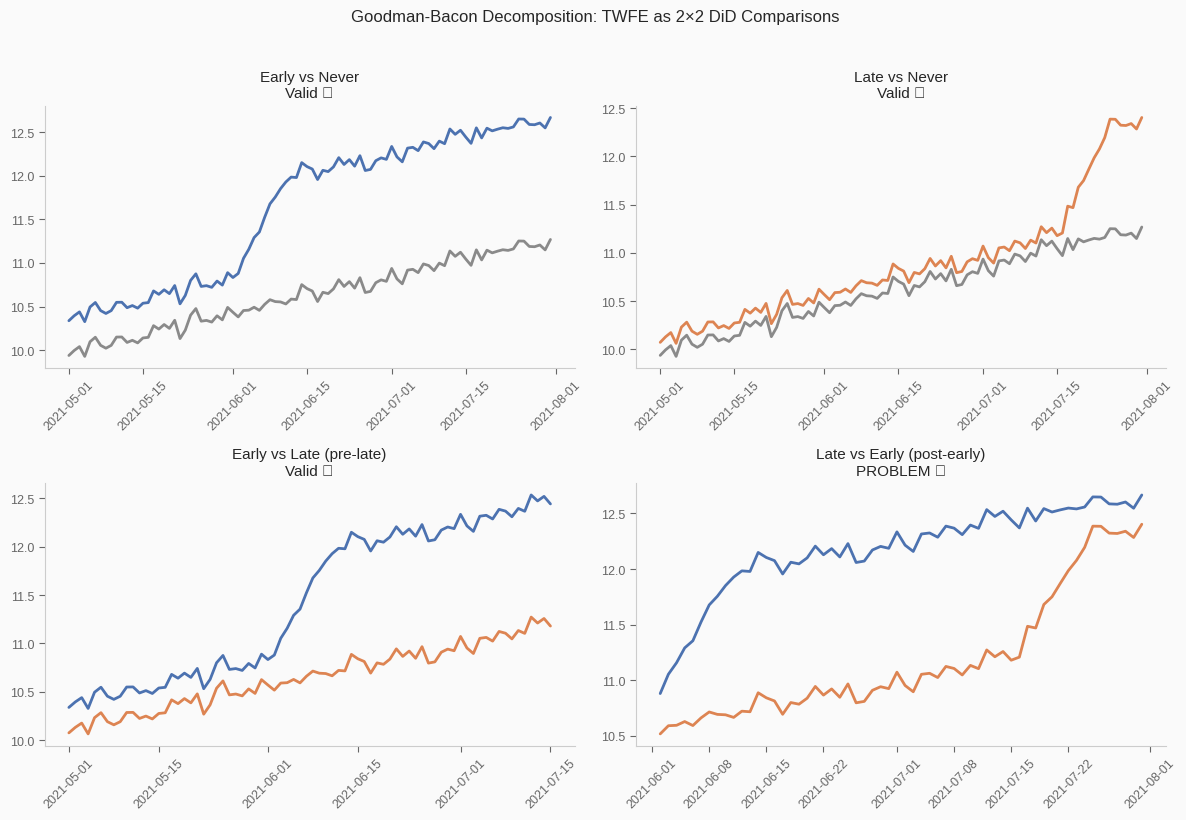

In [5]:
# Visualize the four 2x2 DiD comparisons
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

g_plot_data = df_heter.groupby(["cohort", "date"])["installs"].mean().reset_index()
g_plot_data['cohort'] = g_plot_data['cohort'].astype(str)

comparisons = [
    ("Early vs Never", "2021-07-15", None, "Valid ✓"),
    ("Late vs Never", "2021-06-01", None, "Valid ✓"),
    ("Early vs Late (pre-late)", "2022-01-01", pd.Timestamp('2021-07-15'), "Valid ✓"),
    ("Late vs Early (post-early)", "2022-01-01", pd.Timestamp('2021-06-01'), "PROBLEM ✗"),
]

for ax, (title, exclude, date_filter, validity) in zip(axes.flat, comparisons):
    apply_tufte_style(ax)
    
    data = g_plot_data[g_plot_data['cohort'] != exclude]
    if date_filter is not None:
        if 'post' in title.lower():
            data = data[data['date'] > date_filter]
        else:
            data = data[data['date'] <= date_filter]
    
    for cohort_str, color in [('2021-06-01', COLORS['blue']), 
                               ('2021-07-15', COLORS['orange']),
                               ('2022-01-01', COLORS['gray'])]:
        cohort_data = data[data['cohort'] == cohort_str]
        if len(cohort_data) > 0:
            alpha = 1.0 if cohort_str != exclude else 0.2
            ax.plot(cohort_data['date'], cohort_data['installs'], 
                   color=color, linewidth=2, alpha=alpha)
    
    ax.set_title(f"{title}\n{validity}", fontsize=11)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Goodman-Bacon Decomposition: TWFE as 2×2 DiD Comparisons', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

### The Forbidden Comparison: Late vs Early

The bottom-right panel shows the problem. When we use early-treated as controls for late-treated:
- The "control" trend includes the ramping treatment effect
- This contaminates the counterfactual projection

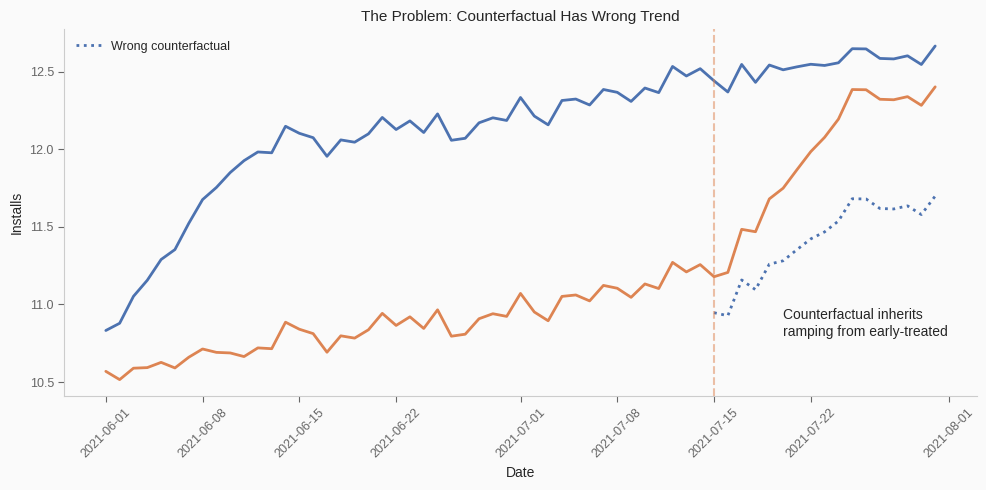

In [6]:
# Focus on the problematic comparison
late_vs_early = (
    df_heter
    [df_heter["date"].astype(str) >= "2021-06-01"]
    [lambda d: d["cohort"].astype(str) <= "2021-08-01"]  # Exclude never-treated
)

# Fit TWFE on just this subset
twfe_subset = smf.ols("installs ~ treat + C(date) + C(unit)", data=late_vs_early).fit()

# Predict counterfactual
late_vs_early_pred = late_vs_early.assign(
    installs_hat_0 = twfe_subset.predict(late_vs_early.assign(treat=0))
)

# Plot
fig, ax = create_tufte_figure(figsize=(10, 5))

cohort_data = late_vs_early_pred.groupby(["cohort", "date"])[["installs", "installs_hat_0"]].mean().reset_index()

# Actual outcomes
for cohort_val, color in [(cohorts[0], COLORS['blue']), (cohorts[1], COLORS['orange'])]:
    data = cohort_data[cohort_data['cohort'] == cohort_val]
    ax.plot(data['date'], data['installs'], color=color, linewidth=2)

# Counterfactual for late cohort (after its treatment)
late_cf = cohort_data[(cohort_data['cohort'] == cohorts[1]) & 
                      (cohort_data['date'] >= pd.Timestamp('2021-07-15'))]
ax.plot(late_cf['date'], late_cf['installs_hat_0'], 
        color=COLORS['blue'], linewidth=2, linestyle=':', label='Wrong counterfactual')

ax.axvline(x=pd.Timestamp('2021-07-15'), color=COLORS['orange'], linestyle='--', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Installs')
ax.set_title('The Problem: Counterfactual Has Wrong Trend')
ax.legend()
ax.annotate('Counterfactual inherits\nramping from early-treated', 
            xy=(pd.Timestamp('2021-07-20'), 10.8), fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Extreme Case: Sign Reversal

The bias can be so severe that it reverses the sign of the true effect!

In [7]:
# Extreme example: NEGATIVE effect that DECREASES over time
date_ext = pd.date_range("2021-05-15", "2021-07-01", freq="D")
cohorts_ext = pd.to_datetime(["2021-06-01", "2021-06-15"])

np.random.seed(1)

df_extreme = pd.DataFrame(dict(
    date = np.tile(date_ext, len(units)),
    unit = np.repeat(units, len(date_ext)),
    cohort = np.repeat(np.random.choice(cohorts_ext, len(units)), len(date_ext)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date_ext)),
)).assign(
    trend = 0,  # No trend
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + 0.1*d["unit_fe"],
).assign(
    # NEGATIVE effect that INCREASES in magnitude (gets more negative)
    y1 = lambda d: d["y0"] - 0.1 * np.maximum(0, (d["date"] - d["cohort"]).dt.days)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

# TWFE
twfe_extreme = smf.ols("installs ~ treat + C(date) + C(unit)", data=df_extreme).fit()

print("Extreme Example: TWFE Sign Reversal")
print(f"  True ATT: {df_extreme.query('treat==1')['tau'].mean():.4f} (NEGATIVE)")
print(f"  TWFE estimate: {twfe_extreme.params['treat']:.4f} (POSITIVE!)")
print(f"\n⚠️  TWFE estimates POSITIVE effect when true effect is NEGATIVE!")

Extreme Example: TWFE Sign Reversal
  True ATT: -1.2191 (NEGATIVE)
  TWFE estimate: 0.0500 (POSITIVE!)

⚠️  TWFE estimates POSITIVE effect when true effect is NEGATIVE!


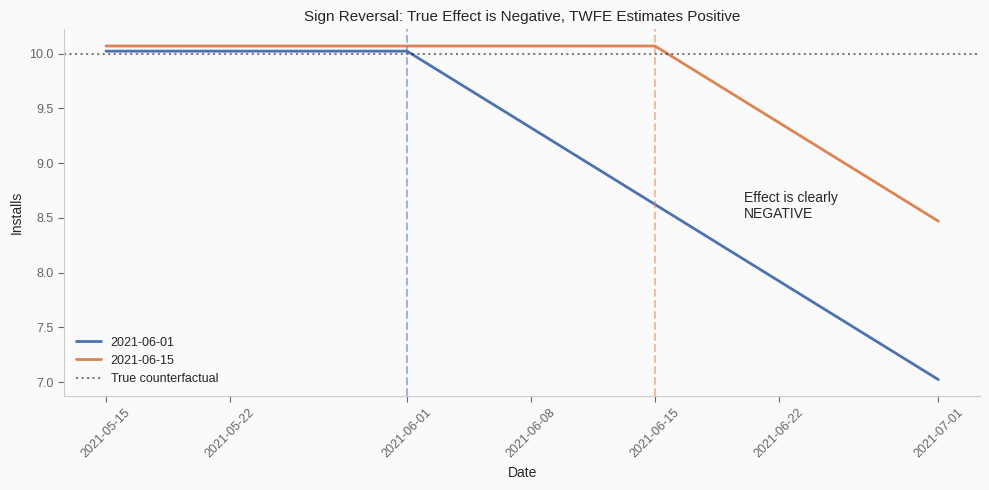

In [8]:
# Visualize sign reversal
fig, ax = create_tufte_figure(figsize=(10, 5))

cohort_data = df_extreme.groupby(["cohort", "date"])["installs"].mean().reset_index()

for cohort_val, color in zip(cohorts_ext, [COLORS['blue'], COLORS['orange']]):
    data = cohort_data[cohort_data['cohort'] == cohort_val]
    ax.plot(data['date'], data['installs'], color=color, linewidth=2, label=str(cohort_val.date()))

ax.axvline(x=cohorts_ext[0], color=COLORS['blue'], linestyle='--', alpha=0.5)
ax.axvline(x=cohorts_ext[1], color=COLORS['orange'], linestyle='--', alpha=0.5)

# True counterfactual (horizontal at ~10)
ax.axhline(y=10, color='black', linestyle=':', alpha=0.5, label='True counterfactual')

ax.set_xlabel('Date')
ax.set_ylabel('Installs')
ax.set_title('Sign Reversal: True Effect is Negative, TWFE Estimates Positive')
ax.legend()

ax.annotate('Effect is clearly\nNEGATIVE', xy=(pd.Timestamp('2021-06-20'), 8.5), fontsize=10)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

## 5. Interview Appendix <a name="interview"></a>

### Q1: Why does TWFE fail with staggered adoption and time-varying effects?

<details>
<summary>Solution</summary>

**Root cause**: TWFE uses already-treated units as controls for later-treated units.

**Mechanism**:
1. TWFE is a weighted average of all 2×2 DiD comparisons
2. One comparison uses "early treated" as controls for "late treated"
3. If early treatment effect is still changing, the control trend is contaminated
4. Contaminated trend → wrong counterfactual → biased estimate

**Goodman-Bacon (2021)**: $\text{plim}\, \hat{\tau}^{TWFE} = \text{VWATT} - \Delta\text{ATT}$

The $\Delta\text{ATT}$ bias term captures how much the effect changes over time.

</details>

### Q2: What is the Goodman-Bacon decomposition?

<details>
<summary>Solution</summary>

**Key insight**: TWFE coefficient = weighted average of all 2×2 DiD estimates.

**With 3 cohorts (early, late, never)**:
1. Early vs Never (valid)
2. Late vs Never (valid)
3. Early vs Late, before late treatment (valid)
4. Late vs Early, after early treatment (**problematic**)

**Weights depend on**:
- Sample sizes
- Treatment variance (how much variation in $D_{it}$)

**Implication**: Even if most comparisons are valid, the "forbidden" comparison can dominate if it has high weight.

</details>

### Q3: How can you detect TWFE bias in practice?

<details>
<summary>Solution</summary>

**Visual diagnostics**:
1. Plot outcomes by cohort over time
2. Look for non-parallel post-treatment trends
3. Check if early-treated "control" trend matches never-treated

**Formal tests**:
1. **Event study**: Plot $\tau_k$ coefficients by time-since-treatment
   - If coefficients vary significantly, effects are time-heterogeneous
2. **Pre-treatment placebo**: Coefficients before treatment should be ~0
   - Non-zero pre-treatment effects suggest problems

**Best practice**: Always run flexible TWFE (cohort × time interactions) and compare to standard TWFE.

</details>

---

## 6. References <a name="references"></a>

1. **Goodman-Bacon, A.** (2021). *Difference-in-Differences with Variation in Treatment Timing*. Journal of Econometrics.

2. **de Chaisemartin, C. & D'Haultfoeuille, X.** (2020). *Two-Way Fixed Effects Estimators with Heterogeneous Treatment Effects*. American Economic Review.

3. **Borusyak, K., Jaravel, X., & Spiess, J.** (2021). *Revisiting Event Study Designs: Robust and Efficient Estimation*. Working Paper.

4. **Facure, M.** (2022). *Causal Inference for the Brave and True*, Chapter 24.